In [1]:
!pip install ipympl

In [2]:
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D

In [3]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import random
import os
import time
from utils import *

In [4]:
print("Pytorch version: ... {} ".format(torch.__version__))
print("Python version ... {}".format(sys.version))

Pytorch version: ... 2.0.1 
Python version ... 3.10.11 (main, Apr 20 2023, 19:02:41) [GCC 11.2.0]


In [5]:
# compute epoch time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [6]:
def get_random_DH_1():
    
    # nDoF: number of degrees of freedom
    max_nDoF = 10
    link_length_range = (100/1000, 1000/1000)
    
    nDoF = torch.randint(2, max_nDoF, (1,1))
    rDH = torch.zeros(nDoF, 4)
    
    # rDH[:,0]: theta
    rDH[:,0] = torch.rand(nDoF)
    #qlim = torch.zeros(nDoF,2)
    #qlim[:,0] = -torch.pi 
    #qlim[:,1] = torch.pi 
    #rDH[:,0] = torch.distributions.uniform.Uniform(qlim[:,0], qlim[:,1]).sample()
    
    # rDH[:,1]: d
    rDH[:,1] = torch.empty(nDoF, dtype=torch.float32).uniform_(link_length_range[0], link_length_range[1])
    
    # rDH[:,2]: a
    rDH[:,2] = torch.empty(nDoF, dtype=torch.float32).uniform_(link_length_range[0], link_length_range[1]) 
    
    # rDH[:,3]: alpha
    alpha_choice = [0, torch.pi,torch.pi/2,torch.pi/3]
    alpha_signs = [-1, 1]
    rDH[:,3] = torch.tensor(
                            [random.choice(alpha_choice) * random.choice(alpha_signs) for _ in range(nDoF)],
                            dtype=torch.float32
                            )
    
    T = forward_kinematics(rDH)

    #if not is_orthogonal(T):
    #    print(f"Warning: Transformation matrix from joint 1 to joint {i+1} is not orthogonal.")
    
    return rDH, nDoF
    



def get_random_DH(nDoF):
    
    # nDoF: number of degrees of freedom
    link_length_range = (100/1000, 1000/1000)
    rDH = torch.zeros(nDoF, 4)
    
    # rDH[:,0]: theta
    rDH[:,0] = torch.rand(nDoF)
    #qlim = torch.zeros(nDoF,2)
    #qlim[:,0] = -torch.pi 
    #qlim[:,1] = torch.pi 
    #rDH[:,0] = torch.distributions.uniform.Uniform(qlim[:,0], qlim[:,1]).sample()
    
    # rDH[:,1]: d
    rDH[:,1] = torch.empty(nDoF, dtype=torch.float32).uniform_(link_length_range[0], link_length_range[1])
    
    # rDH[:,2]: a
    rDH[:,2] = torch.empty(nDoF, dtype=torch.float32).uniform_(link_length_range[0], link_length_range[1]) 
    
    # rDH[:,3]: alpha
    alpha_choice = [0, torch.pi,torch.pi/2,torch.pi/3]
    alpha_signs = [-1, 1]
    rDH[:,3] = torch.tensor(
                            [random.choice(alpha_choice) * random.choice(alpha_signs) for _ in range(nDoF)],
                            dtype=torch.float32
                            )

    
    
    T = forward_kinematics(rDH)

    return rDH



def generate_q_lim_commensurate(nDoF):
    """
    Generate a PyTorch tensor of shape (n_rows, 2),
    where each row is [deg2rad(-360), deg2rad(360)].
    """
    
    # Convert -360 and 360 to radians
    lower = torch.deg2rad(torch.tensor(-360.0))
    upper = torch.deg2rad(torch.tensor(360.0))
    
    # Create a single row tensor [lower, upper]
    row = torch.stack([lower, upper])

    # Repeat this row n_rows times
    q_lim = row.unsqueeze(0).repeat(nDoF, 1)
    
    return q_lim
    
    
# Function to check orthogonality of rotation matrix
def is_orthogonal(matrix):
    """
    Check if a rotation matrix is orthogonal by verifying if R * R^T = I.
    """
    rotation_part = matrix[:3, :3]  # Extract rotation part
    return np.allclose(np.dot(rotation_part, rotation_part.T), np.eye(3), atol=1e-6)


In [7]:
# Test the random robot DH generation
rDH, nDoF = get_random_DH_1()
print("Generated {}DoF rDH =\n{}".format(nDoF.item(), rDH))

Generated 6DoF rDH =
tensor([[ 0.8714,  0.7956,  0.2010, -1.5708],
        [ 0.4276,  0.7887,  0.4578,  0.0000],
        [ 0.7813,  0.8332,  0.2555,  1.5708],
        [ 0.5877,  0.9971,  0.7225,  0.0000],
        [ 0.0943,  0.3488,  0.1777,  0.0000],
        [ 0.4183,  0.3851,  0.3843, -1.0472]])


In [8]:
# Seed random generator
torch.manual_seed(0)

# Generation the dataset for multiple robots
num_robots = 10      # TODO: use 1000 
start_nDoF = 3
final_nDoF = 10
data_all = {}
total_count = 0

# Vary the number of degrees of freedom
for nDoF in range(start_nDoF, final_nDoF+1):

    robot_type = "C"

    if robot_type == "C":
        q_lim = generate_q_lim_commensurate(nDoF)
    

    # Vary the joint variation
    for js in range(1,2):

        # Vary the number of robot within this nDoF
        #for r in range(int(num_robots/(final_nDoF-start_nDoF+1))):      
        for r in range(1):
            
            scale = 10
            q_lim = q_lim*(scale/10)

            print("\ngenerated robot: nDoF = {} / r = {}".format(nDoF, r))
            #print("joint limits for scale {}:\n{}".format(scale/10, q_lim))
    
            t0 = torch.distributions.uniform.Uniform(q_lim[:,0], q_lim[:,1]).sample()
            DH = get_random_DH(nDoF)
            DH[:,0] = t0
            print('DH:\n{}'.format(DH))
    
            print("joint range {}:".format(js))
    
            # generate dataset with a specified number of samples
            n_traj = 500
            n_traj_steps = 50
            #n_samples = 100000000
            print_steps = 5
            data_position = []

            # Loop the number of trajectory to generate per robot ndof
            for s in range(n_traj):
                
                t0 = torch.distributions.uniform.Uniform(q_lim[:,0], q_lim[:,1]).sample()
                #DH = get_DH(robot_choice, t0)
                
                DH[:,0] = t0
                T = forward_kinematics(DH)
                R = T[:3,:3]       
                rpy = matrix_to_euler_angles(R, "XYZ")
                #data_position.append(torch.cat([T[:3,-1], rpy, t0]).numpy())  
    
                D_current = torch.cat([T[:3,-1], rpy])
                Q_current = t0
    
                #print(t0)
                t = t0.clone()
                #print(D_current)


                # Loop through the waypoints of the current trajectory
                for i in range(n_traj_steps):
                    
                    if robot_type == "C":
                        t += torch.deg2rad(torch.tensor(js)) # 0.5 
                        
                    elif robot_type == "I": 
                        t[:2] += torch.deg2rad(torch.tensor(js)) # 0.5 
                        t[2] += torch.tensor(js/1000)
                        t[3:] += torch.deg2rad(torch.tensor(js)) # 0.5 
                    #DH = get_DH(robot_choice, t)
                    
                    DH[:,0] = t
                    T = forward_kinematics(DH)
                    R = T[:3,:3]       
                    rpy = matrix_to_euler_angles(R, "XYZ")
    
                    D_previous = D_current.clone()
                    Q_previous = Q_current.clone()
                    D_current = torch.cat([T[:3,-1], rpy])
                    Q_current = t.clone()
    
                    data_position.append(torch.cat([D_previous, Q_previous, D_current, Q_current]).numpy()) 

                if s%(n_traj/print_steps) == 0:
                    print("Generated [{}] trajectories with {} samples...".format(s, i+1))

            data_position_a = np.array(data_position)
            data_all[str(nDoF)+"_"+str(r)] = data_position_a
            total_count += 1
        


print("\n\nGenerated dataset with {} robots ...".format(total_count))

# Save dictionary to a .npy file (pickled)
np.save("data.npy", data_all, allow_pickle=True)


generated robot: nDoF = 3 / r = 0
DH:
tensor([[-0.0470,  0.5411,  0.6691,  1.5708],
        [ 3.3706,  0.9068,  0.4140,  0.0000],
        [-5.1713,  0.5101,  0.4615, -1.5708]])
joint range 1:
Generated [0] trajectories with 50 samples...
Generated [100] trajectories with 50 samples...
Generated [200] trajectories with 50 samples...
Generated [300] trajectories with 50 samples...
Generated [400] trajectories with 50 samples...

generated robot: nDoF = 4 / r = 0
DH:
tensor([[-3.6292,  0.8623,  0.8329,  1.0472],
        [-5.7533,  0.8034,  0.9415,  0.0000],
        [-1.8329,  0.4391,  0.1380,  3.1416],
        [-5.8184,  0.3722,  0.4528, -1.5708]])
joint range 1:
Generated [0] trajectories with 50 samples...
Generated [100] trajectories with 50 samples...
Generated [200] trajectories with 50 samples...
Generated [300] trajectories with 50 samples...
Generated [400] trajectories with 50 samples...

generated robot: nDoF = 5 / r = 0
DH:
tensor([[ 0.7299,  0.1550,  0.3645, -1.5708],
       

In [9]:
data_all

{'3_0': array([[ 1.2226912 , -1.1221924 ,  0.68552613, ..., -5.9851785 ,
         -4.1437883 , -2.572621  ],
        [ 1.2429452 , -1.1004201 ,  0.69619036, ..., -5.9677253 ,
         -4.126335  , -2.555168  ],
        [ 1.2623906 , -1.0784199 ,  0.7069843 , ..., -5.950272  ,
         -4.108882  , -2.5377147 ],
        ...,
        [-0.7788461 , -1.1962222 ,  1.2597587 , ...,  5.6017756 ,
          2.2714744 , -0.13308962],
        [-0.7728382 , -1.1974777 ,  1.246726  , ...,  5.619229  ,
          2.2889276 , -0.11563633],
        [-0.766717  , -1.1991282 ,  1.2331228 , ...,  5.636682  ,
          2.3063807 , -0.09818304]], dtype=float32),
 '4_0': array([[-0.8769072 , -0.9583087 ,  0.38118207, ..., -2.2574425 ,
          5.3814654 , -0.9106449 ],
        [-0.8498322 , -0.9920043 ,  0.36355966, ..., -2.2399893 ,
          5.3989186 , -0.8931916 ],
        [-0.8213937 , -1.0251291 ,  0.34621993, ..., -2.222536  ,
          5.416372  , -0.87573826],
        ...,
        [-0.84816533, -0.

Shape of visualized dataset:  (25000, 32)


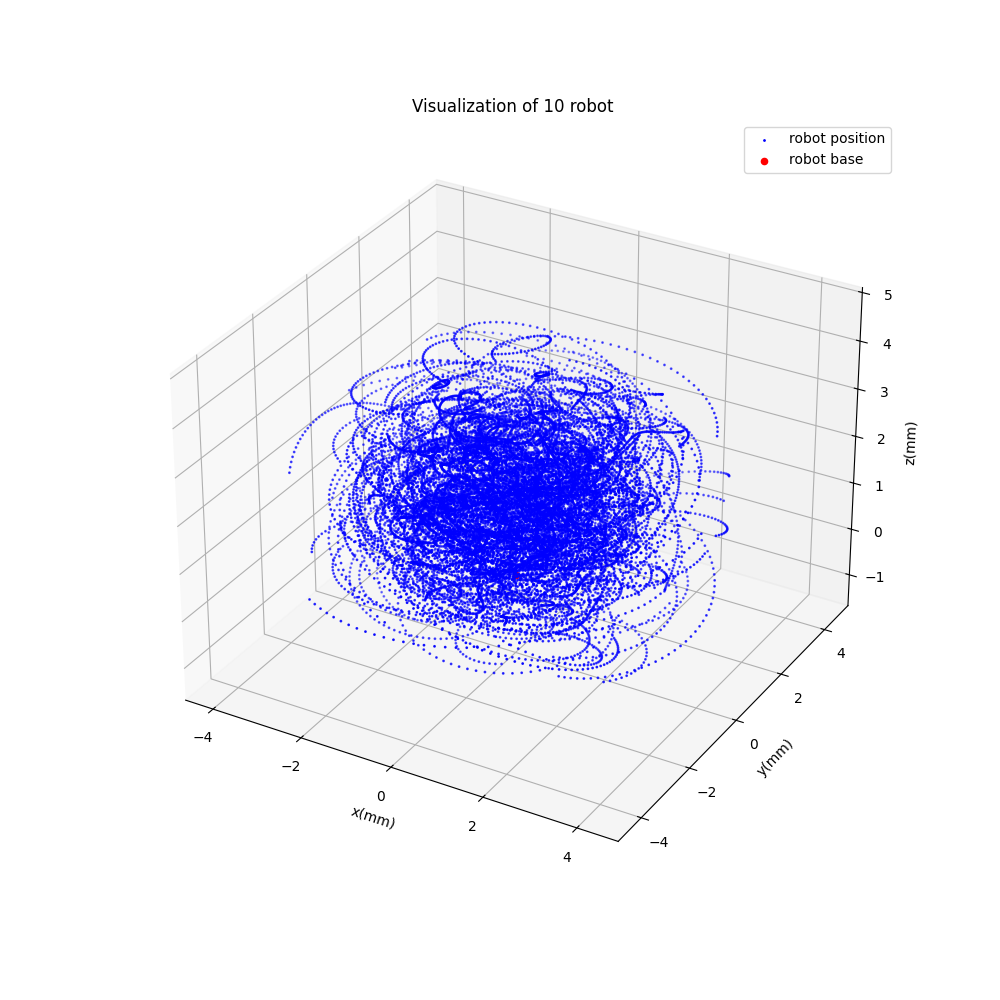

In [17]:
curr_nDoF = 10
curr_robot = data_all[str(curr_nDoF) + '_0']
print("Shape of visualized dataset: ", curr_robot.shape)


### Visualize 4DoF Dataset
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter(curr_robot[:,0], curr_robot[:,1], curr_robot[:,2], s=4, c='b', marker='.')
ax.scatter(0,0,0,s=20, marker='o', c='r')
ax.legend(["robot position","robot base"])
ax.set(xlabel='x(mm)', ylabel='y(mm)', zlabel='z(mm)',
       title='Visualization of '+ str(curr_nDoF) + ' robot')
#ax.view_init(60, 25)
plt.show()